# 作业2 频繁项集与关联规则挖掘
## github地址：https://github.com/chen-zi-han/datamining/tree/main/%E4%BD%9C%E4%B8%9A2

## 1 对数据集进行处理，转换成适合进行关联规则挖掘的形式

### 使用wine的130k_v2数据集，由第一次作业可以分析，数据存在缺失、离散点等情况

In [4]:
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
csv_file_path = './input/winemag-data-130k-v2.csv'
data = pd.read_csv(csv_file_path, encoding="utf-8")

### description等属性对于数据挖掘分析影响有限，暂不考虑
列名解释 country: 葡萄酒生产国家 description: 葡萄酒的评价描述 designation: 酿造葡萄酒的葡萄园 points: 对葡萄酒的评分 price: 葡萄酒的价格 province: 来自的州或省份 region_1: 葡萄酒来自的产地 region_2: 葡萄酒来自的产地 variety: 酿葡萄酒的葡萄品种 winery: 葡萄酒的酿酒厂

In [6]:
# 进行数据分析前应将预处理转化为数据挖掘合适的形式
data.isnull().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

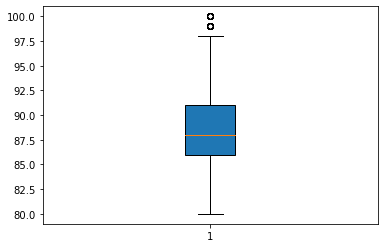

In [7]:
# 去重
data = data.drop_duplicates(subset=["country","description","designation","points","province","taster_name","taster_twitter_handle","variety","winery"],keep='first')
data = data.reset_index(drop = True)

# 分析points，发现离散点
bplt = plt.boxplot(data['points'], notch=False, sym='o', vert=True, patch_artist=True)

In [8]:
# 分析country price points variety winery，鉴于缺失值不到1%，直接在分析价格关联规则时舍弃缺失值
attri = "price" 
newdata = data.dropna(subset=["price","points","country","variety"])
newdata.isnull().sum()
# bplt = plt.boxplot(newdata['price'], notch=False, sym='o', vert=True, patch_artist=True)

Unnamed: 0                   0
country                      0
description                  0
designation              32049
points                       0
price                        0
province                     0
region_1                 17957
region_2                 64968
taster_name              23271
taster_twitter_handle    27754
title                        0
variety                      0
winery                       0
dtype: int64

In [9]:
newdatafen = newdata[["price","points","country","variety","winery"]]
newdatafen

,price,points,country,variety,winery
1,15.0,87,Portugal,Portuguese Red,Quinta dos Avidagos
2,14.0,87,US,Pinot Gris,Rainstorm
3,13.0,87,US,Riesling,St. Julian
4,65.0,87,US,Pinot Noir,Sweet Cheeks
5,15.0,87,Spain,Tempranillo-Merlot,Tandem
...,...,...,...,...,...
119982,28.0,90,Germany,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
119983,75.0,90,US,Pinot Noir,Citation
119984,30.0,90,France,Gewürztraminer,Domaine Gresser
119985,32.0,90,France,Pinot Gris,Domaine Marcel Deiss


count    111536.000000
mean         88.413813
std           3.099257
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

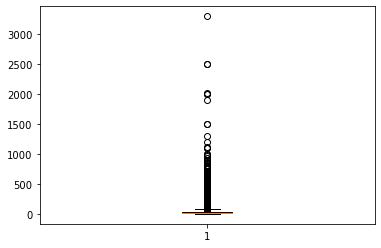

In [10]:
bplt = plt.boxplot(newdatafen['price'], notch=False, sym='o', vert=True, patch_artist=True)
newdatafen['points'].describe()

可以看到价格集中在0-100美元之间  

<AxesSubplot:label='86e99002-8b1f-4baa-9ee6-ab4e560eddf5'>

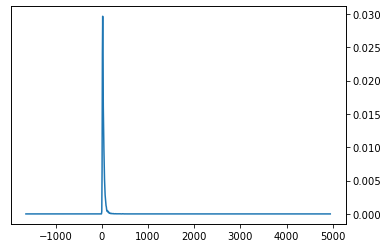

In [46]:
newdatafen['price'].plot(kind = 'kde', secondary_y=True)

In [11]:
# 数据离散化，将价格除以10，将所有超过100美元项设置为11
def points_discretization(value):
    return "points-"+str(int(value)//4)
newdatafen['points'] = pd.DataFrame(newdatafen['points'].apply(points_discretization))

newdatafen

<ipython-input-11-b8cf76579ec7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdatafen['points'] = pd.DataFrame(newdatafen['points'].apply(points_discretization))


,price,points,country,variety,winery
1,15.0,points-21,Portugal,Portuguese Red,Quinta dos Avidagos
2,14.0,points-21,US,Pinot Gris,Rainstorm
3,13.0,points-21,US,Riesling,St. Julian
4,65.0,points-21,US,Pinot Noir,Sweet Cheeks
5,15.0,points-21,Spain,Tempranillo-Merlot,Tandem
...,...,...,...,...,...
119982,28.0,points-22,Germany,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
119983,75.0,points-22,US,Pinot Noir,Citation
119984,30.0,points-22,France,Gewürztraminer,Domaine Gresser
119985,32.0,points-22,France,Pinot Gris,Domaine Marcel Deiss


In [12]:
print(newdatafen['price'].describe(),"\n")

count    111536.000000
mean         35.626282
std          42.113251
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64 



In [13]:
def price_discretization(price):
    if int(price) <= 100:
        return "price-"+str(int(price)//10)
    else:
        return "price-11"
newdatafen['price'] = newdatafen['price'].apply(price_discretization)

<ipython-input-13-f834d3ee0e46>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdatafen['price'] = newdatafen['price'].apply(price_discretization)


In [14]:
newdatafen

,price,points,country,variety,winery
1,price-1,points-21,Portugal,Portuguese Red,Quinta dos Avidagos
2,price-1,points-21,US,Pinot Gris,Rainstorm
3,price-1,points-21,US,Riesling,St. Julian
4,price-6,points-21,US,Pinot Noir,Sweet Cheeks
5,price-1,points-21,Spain,Tempranillo-Merlot,Tandem
...,...,...,...,...,...
119982,price-2,points-22,Germany,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
119983,price-7,points-22,US,Pinot Noir,Citation
119984,price-3,points-22,France,Gewürztraminer,Domaine Gresser
119985,price-3,points-22,France,Pinot Gris,Domaine Marcel Deiss


## 2 找出频繁模式

In [34]:
tmp1datafen = newdatafen[["price","points","country"]]
tmp1datafen
# tmp2datafen = pd.get_dummies(newdatafen[["price","points","country","variety"]])
# tmp2datafen

,price,points,country
1,price-1,points-21,Portugal
2,price-1,points-21,US
3,price-1,points-21,US
4,price-6,points-21,US
5,price-1,points-21,Spain
...,...,...,...
119982,price-2,points-22,Germany
119983,price-7,points-22,US
119984,price-3,points-22,France
119985,price-3,points-22,France


In [36]:
tmp1datafen = pd.get_dummies(tmp1datafen)
tmp1datafen

,price_price-0,price_price-1,price_price-10,price_price-11,price_price-2,price_price-3,price_price-4,price_price-5,price_price-6,price_price-7,...,country_Serbia,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,country_Switzerland,country_Turkey,country_US,country_Ukraine,country_Uruguay
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119982,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119983,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
119984,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119985,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


使用Apriori算法计算频繁模式，设置最小支持度为0.01，最大长度为3

In [58]:
from mlxtend.frequent_patterns import apriori
frequent_1 = apriori(tmp1datafen, min_support=0.01, use_colnames=True, max_len=3).sort_values(by='support', ascending=False)
print(frequent_1.shape)
frequent_1

(113, 2)


,support,itemsets
26,0.450420,(country_US)
13,0.423209,(points_points-22)
12,0.352263,(points_points-21)
1,0.302127,(price_price-1)
3,0.238883,(price_price-2)
...,...,...
112,0.010472,"(country_US, price_price-6, points_points-23)"
61,0.010400,"(country_Italy, price_price-5)"
39,0.010355,"(price_price-2, points_points-20)"
92,0.010337,"(price_price-1, country_Portugal, points_point..."


## 3 导出关联规则，计算其支持度和置信度

### 导出关联规则

In [61]:
from mlxtend.frequent_patterns import association_rules	
access_rule0 = association_rules(frequent_1, metric='confidence', min_threshold=0.4).sort_values(by='confidence', ascending=False)  	
access_rule0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
50,"(country_Chile, points_points-21)",(price_price-1),0.019725,0.302127,0.015062,0.763636,2.527537,0.009103,2.952541
64,"(points_points-21, country_Argentina)",(price_price-1),0.014166,0.302127,0.010624,0.750000,2.482403,0.006344,2.791493
28,"(country_Italy, price_price-1)",(points_points-21),0.038902,0.352263,0.027695,0.711915,2.020977,0.013991,2.248425
31,"(price_price-3, points_points-21)",(country_US),0.035997,0.450420,0.024907,0.691905,1.536135,0.008693,1.783804
45,(price_price-0),(points_points-21),0.024181,0.352263,0.016551,0.684464,1.943049,0.008033,2.052816
...,...,...,...,...,...,...,...,...,...
0,(country_US),(points_points-22),0.450420,0.423209,0.189580,0.420897,0.994537,-0.001041,0.996007
13,"(price_price-2, points_points-22)",(country_US),0.123987,0.450420,0.052171,0.420782,0.934201,-0.003675,0.948832
17,"(country_US, price_price-2)",(points_points-21),0.113533,0.352263,0.046523,0.409777,1.163269,0.006530,1.097444
51,(country_Chile),"(price_price-1, points_points-21)",0.037019,0.178041,0.015062,0.406878,2.285304,0.008471,1.385818


### 计算其支持度和置信度

In [62]:
for index,row in access_rule0.iterrows():
    print('由{}\t-->{}\t的支持度为；{}\t置信度为：{}'.format(tuple(row['antecedents']),tuple(row['consequents']),row['support'],row['confidence']))

由('country_Chile', 'points_points-21')	-->('price_price-1',)	的支持度为；0.01506240137713384	置信度为：0.7636363636363637
由('points_points-21', 'country_Argentina')	-->('price_price-1',)	的支持度为；0.010624372399942619	置信度为：0.75
由('country_Italy', 'price_price-1')	-->('points_points-21',)	的支持度为；0.027695093960694306	置信度为：0.7119151878312975
由('price_price-3', 'points_points-21')	-->('country_US',)	的支持度为；0.02490675656290346	置信度为：0.6919053549190536
由('price_price-0',)	-->('points_points-21',)	的支持度为；0.01655071008463635	置信度为：0.6844642195031516
由('price_price-4', 'points_points-21')	-->('country_US',)	的支持度为；0.011736121073016784	置信度为：0.6839080459770116
由('country_Chile', 'price_price-1')	-->('points_points-21',)	的支持度为；0.01506240137713384	置信度为：0.6768734891216761
由('price_price-3', 'country_Italy')	-->('points_points-22',)	的支持度为；0.011027829579687275	置信度为：0.6598712446351931
由('points_points-21', 'country_Spain')	-->('price_price-1',)	的支持度为；0.01503550423181753	置信度为：0.6487427466150871
由('country_Portugal', 'points

## 4 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种

### 我们这里计算Lift（已经计算了）,全置信度(all_conf)和不平衡比(IR)
lift(A->B) = confidence(A->B)/support(B)

all_confidence(A->B) = confidence(A->B)/max(confidence(A),confidence(B))

IR(A->B) = |support(A)-support(B)|/(support(A)+support(B)-support(A->B))

In [66]:
def all_confidence(conAB,conA,conB):
    return  conAB/max(conA,conB)
def IR(supAB,supA,aupB):
    return abs(supA-aupB)/(supA+aupB-supAB)

allconf=[]
ir=[]

for idx,row in access_rule0.iterrows():
    allconf.append(all_confidence(row['support'],row['antecedent support'],row['consequent support']))
    ir.append(IR(row['support'],row['antecedent support'],row['consequent support']))
access_rule0['allconf'] = allconf
access_rule0['ir'] = ir
access_rule0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,allconf,ir
50,"(country_Chile, points_points-21)",(price_price-1),0.019725,0.302127,0.015062,0.763636,2.527537,0.009103,2.952541,0.049855,0.920510
64,"(points_points-21, country_Argentina)",(price_price-1),0.014166,0.302127,0.010624,0.750000,2.482403,0.006344,2.791493,0.035165,0.942070
28,"(country_Italy, price_price-1)",(points_points-21),0.038902,0.352263,0.027695,0.711915,2.020977,0.013991,2.248425,0.078621,0.862136
31,"(price_price-3, points_points-21)",(country_US),0.035997,0.450420,0.024907,0.691905,1.536135,0.008693,1.783804,0.055297,0.897970
45,(price_price-0),(points_points-21),0.024181,0.352263,0.016551,0.684464,1.943049,0.008033,2.052816,0.046984,0.911612
...,...,...,...,...,...,...,...,...,...,...,...
0,(country_US),(points_points-22),0.450420,0.423209,0.189580,0.420897,0.994537,-0.001041,0.996007,0.420897,0.039779
13,"(price_price-2, points_points-22)",(country_US),0.123987,0.450420,0.052171,0.420782,0.934201,-0.003675,0.948832,0.115829,0.625069
17,"(country_US, price_price-2)",(points_points-21),0.113533,0.352263,0.046523,0.409777,1.163269,0.006530,1.097444,0.132069,0.569391
51,(country_Chile),"(price_price-1, points_points-21)",0.037019,0.178041,0.015062,0.406878,2.285304,0.008471,1.385818,0.084601,0.705115


去除全置信度小于0.05和不平衡比大于0.95的数值,从而得到可以用于分析的关联规则

In [68]:
access_rule0 = access_rule0[access_rule0['allconf']>=0.05]
access_rule0 = access_rule0[access_rule0['ir']<=0.95]
access_rule0.sort_values(by='allconf', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,allconf,ir
3,(points_points-21),(price_price-1),0.352263,0.302127,0.178041,0.505421,1.672879,0.071613,1.411046,0.505421,0.105251
2,(price_price-1),(points_points-21),0.302127,0.352263,0.178041,0.589293,1.672879,0.071613,1.577127,0.505421,0.105251
0,(country_US),(points_points-22),0.450420,0.423209,0.189580,0.420897,0.994537,-0.001041,0.996007,0.420897,0.039779
1,(points_points-22),(country_US),0.423209,0.450420,0.189580,0.447959,0.994537,-0.001041,0.995542,0.420897,0.039779
4,(points_points-21),(country_US),0.352263,0.450420,0.148436,0.421379,0.935527,-0.010230,0.949811,0.329551,0.150030
5,(price_price-2),(points_points-22),0.238883,0.423209,0.123987,0.519029,1.226413,0.022890,1.199222,0.292969,0.342547
6,(price_price-2),(country_US),0.238883,0.450420,0.113533,0.475266,1.055164,0.005935,1.047351,0.252060,0.367399
7,(points_points-23),(country_US),0.166655,0.450420,0.084547,0.507317,1.126320,0.009482,1.115484,0.187707,0.532864
8,(price_price-3),(country_US),0.141515,0.450420,0.083695,0.591422,1.313046,0.019954,1.345104,0.185816,0.607794
9,(price_price-3),(points_points-22),0.141515,0.423209,0.076935,0.543652,1.284595,0.017044,1.263928,0.181789,0.577491


## 5 对挖掘结果进行分析

In [104]:
tmp2datafen = pd.get_dummies(newdatafen[["price","points"]])
tmp2datafen = pd.get_dummies(tmp2datafen)
frequent_2 = apriori(tmp2datafen, min_support=0.01, use_colnames=True, max_len=2).sort_values(by='support', ascending=False)
print(frequent_2.shape)
frequent_2

(36, 2)


,support,itemsets
13,0.423209,(points_points-22)
12,0.352263,(points_points-21)
1,0.302127,(price_price-1)
3,0.238883,(price_price-2)
17,0.178041,"(price_price-1, points_points-21)"
14,0.166655,(points_points-23)
4,0.141515,(price_price-3)
22,0.123987,"(price_price-2, points_points-22)"
5,0.099950,(price_price-4)
18,0.092508,"(price_price-1, points_points-22)"


In [70]:
tmp3datafen = pd.get_dummies(newdatafen[["country","points"]])
tmp3datafen = pd.get_dummies(tmp3datafen)
frequent_3 = apriori(tmp3datafen, min_support=0.02, use_colnames=True, max_len=2).sort_values(by='support', ascending=False)
print(frequent_3.shape)
access_rule1 = association_rules(frequent_3, metric='confidence', min_threshold=0.3).sort_values(by='confidence', ascending=False)
access_rule1

(23, 2)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(points_points-23),(country_US),0.166655,0.450420,0.084547,0.507317,1.126320,0.009482,1.115484
9,(points_points-20),(country_US),0.050674,0.450420,0.024710,0.487615,1.082579,0.001885,1.072593
5,(country_Italy),(points_points-22),0.139013,0.423209,0.064132,0.461335,1.090089,0.005300,1.070779
1,(points_points-22),(country_US),0.423209,0.450420,0.189580,0.447959,0.994537,-0.001041,0.995542
6,(country_France),(points_points-22),0.146016,0.423209,0.062527,0.428221,1.011843,0.000732,1.008765
10,(country_Spain),(points_points-21),0.054234,0.352263,0.023176,0.427343,1.213137,0.004072,1.131109
3,(points_points-21),(country_US),0.352263,0.450420,0.148436,0.421379,0.935527,-0.010230,0.949811
0,(country_US),(points_points-22),0.450420,0.423209,0.189580,0.420897,0.994537,-0.001041,0.996007
8,(country_Italy),(points_points-21),0.139013,0.352263,0.050558,0.363689,1.032437,0.001588,1.017957
7,(country_France),(points_points-21),0.146016,0.352263,0.051006,0.349318,0.991641,-0.000430,0.995475


通过过滤后的关联规则，我们可以看到酒类的价格高和评分高的确成相关性，但是价格过高的酒由于数量极少难以被频繁项集捕捉。
(points_points-21)->(price_price-1)可以看出，低分酒大概率是便宜的酒。
(country_Argentina)->(price_price-1)可以看出，阿根廷红酒较为便宜。
可以看到美国酒的分数分布跨度较大

## 6 可视化展示

<AxesSubplot:xlabel='support', ylabel='ir'>

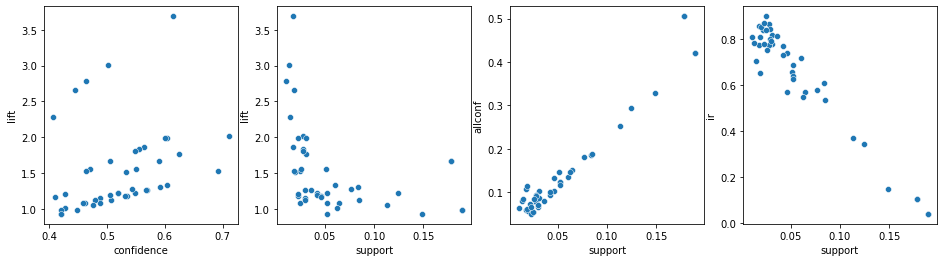

In [101]:
f, axs = plt.subplots(1,4, figsize=(16,4))
sns.scatterplot(x=access_rule0.support,y=access_rule0.confidence,ax=axs[0])
sns.scatterplot(x=access_rule0.support,y=access_rule0.lift,ax=axs[1])
sns.scatterplot(x=access_rule0.support,y=access_rule0.allconf,ax=axs[2])
sns.scatterplot(x=access_rule0.support,y=access_rule0.ir,ax=axs[3])

### 可以看出allconf和support线性相关，lift和support负相关

In [109]:
tmp4datafen = pd.get_dummies(newdatafen[["price","country"]])
tmp4datafen = pd.get_dummies(tmp4datafen)
frequent_4 = apriori(tmp4datafen, min_support=0.01, use_colnames=True, max_len=2).sort_values(by='support', ascending=False)
print(frequent_4.shape)
frequent_4

(44, 2)


,support,itemsets
22,0.450420,(country_US)
1,0.302127,(price_price-1)
3,0.238883,(price_price-2)
15,0.146016,(country_France)
4,0.141515,(price_price-3)
17,0.139013,(country_Italy)
33,0.113533,"(country_US, price_price-2)"
5,0.099950,(price_price-4)
29,0.093154,"(country_US, price_price-1)"
36,0.083695,"(price_price-3, country_US)"


可以看出法国红酒价格贵，西班牙便宜

<AxesSubplot:xlabel='support', ylabel='confidence'>

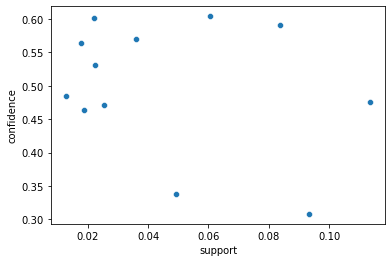

In [110]:
access_rule4 = association_rules(frequent_4, metric='confidence', min_threshold=0.3).sort_values(by='confidence', ascending=False)
access_rule4
sns.scatterplot(x=access_rule4.support,y=access_rule4.confidence)

国家-价格的confidence-support可视化结果如上